**Deep Learning Assignment 1: Python Code Notebook for Implementation of Inception v4 on Covid dataset**

**Author:** Srirupa Guha

**Date:** 3rd Oct 2021

**Email id:** srirupaguha18@gmail.com

Mounting the Google Drive to load Covid dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing necessary libraries**

In [ ]:
# Implementation of Inception-v4 architecture

# Importing the libraries
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

**Defining functions for Convolutional Block, Stem, Inception A, B, C, Reduction A, B and Inceptionv4**

In [ ]:
def conv_block(x, nb_filter, nb_row, nb_col, padding = "same", strides = (1, 1), use_bias = False):
    '''Defining a Convolution block that will be used throughout the network.'''

    x = Conv2D(nb_filter, (nb_row, nb_col), strides = strides, padding = padding, use_bias = use_bias)(x)
    x = BatchNormalization(axis = -1, momentum = 0.9997, scale = False)(x)
    x = Activation("relu")(x)

    return x

def stem(input):
    '''The stem of the pure Inception-v4 and Inception-ResNet-v2 networks. This is input part of those networks.'''

    # Input shape is 299 * 299 * 3 (Tensorflow dimension ordering)
    x = conv_block(input, 32, 3, 3, strides = (2, 2), padding = "same") # 149 * 149 * 32
    x = conv_block(x, 32, 3, 3, padding = "same") # 147 * 147 * 32
    x = conv_block(x, 64, 3, 3) # 147 * 147 * 64

    x1 = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(x)
    x2 = conv_block(x, 96, 3, 3, strides = (2, 2), padding = "same")

    x = concatenate([x1, x2], axis = -1) # 73 * 73 * 160

    x1 = conv_block(x, 64, 1, 1)
    x1 = conv_block(x1, 96, 3, 3, padding = "same")

    x2 = conv_block(x, 64, 1, 1)
    x2 = conv_block(x2, 64, 1, 7)
    x2 = conv_block(x2, 64, 7, 1)
    x2 = conv_block(x2, 96, 3, 3, padding = "same")

    x = concatenate([x1, x2], axis = -1) # 71 * 71 * 192

    x1 = conv_block(x, 192, 3, 3, strides = (2, 2), padding = "same")

    x2 = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(x)

    x = concatenate([x1, x2], axis = -1) # 35 * 35 * 384

    return x

def inception_A(input):
    '''Architecture of Inception_A block which is a 35 * 35 grid module.'''

    a1 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input)
    a1 = conv_block(a1, 96, 1, 1)

    a2 = conv_block(input, 96, 1, 1)

    a3 = conv_block(input, 64, 1, 1)
    a3 = conv_block(a3, 96, 3, 3)

    a4 = conv_block(input, 64, 1, 1)
    a4 = conv_block(a4, 96, 3, 3)
    a4 = conv_block(a4, 96, 3, 3)

    merged = concatenate([a1, a2, a3, a4], axis = -1)

    return merged

def inception_B(input):
    '''Architecture of Inception_B block which is a 17 * 17 grid module.'''

    b1 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input)
    b1 = conv_block(b1, 128, 1, 1)

    b2 = conv_block(input, 384, 1, 1)

    b3 = conv_block(input, 192, 1, 1)
    b3 = conv_block(b3, 224, 1, 7)
    b3 = conv_block(b3, 256, 7, 1)

    b4 = conv_block(input, 192, 1, 1)
    b4 = conv_block(b4, 192, 7, 1)
    b4 = conv_block(b4, 224, 1, 7)
    b4 = conv_block(b4, 224, 7, 1)
    b4 = conv_block(b4, 256, 1, 7)

    merged = concatenate([b1, b2, b3, b4], axis = -1)

    return merged

def inception_C(input):
    '''Architecture of Inception_C block which is a 8 * 8 grid module.'''

    c1 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input)
    c1 = conv_block(c1, 256, 1, 1)

    c2 = conv_block(input, 256, 1, 1)

    c3 = conv_block(input, 384, 1, 1)
    c31 = conv_block(c2, 256, 1, 3)
    c32 = conv_block(c2, 256, 3, 1)
    c3 = concatenate([c31, c32], axis = -1)

    c4 = conv_block(input, 384, 1, 1)
    c4 = conv_block(c3, 448, 3, 1)
    c4 = conv_block(c3, 512, 1, 3)
    c41 = conv_block(c3, 256, 1, 3)
    c42 = conv_block(c3, 256, 3, 1)
    c4 = concatenate([c41, c42], axis = -1)

    merged = concatenate([c1, c2, c3, c4], axis = -1)

    return merged

def reduction_A(input, k = 192, l = 224, m = 256, n = 384):
    '''Architecture of a 35 * 35 to 17 * 17 Reduction_A block.'''

    ra1 = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(input)

    ra2 = conv_block(input, n, 3, 3, strides = (2, 2), padding = "same")

    ra3 = conv_block(input, k, 1, 1)
    ra3 = conv_block(ra3, l, 3, 3)
    ra3 = conv_block(ra3, m, 3, 3, strides = (2, 2), padding = "same")

    merged = concatenate([ra1, ra2, ra3], axis = -1)

    return merged

def reduction_B(input):
    '''Architecture of a 17 * 17 to 8 * 8 Reduction_B block.'''

    rb1 = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(input)

    rb2 = conv_block(input, 192, 1, 1)
    rb2 = conv_block(rb2, 192, 3, 3, strides = (2, 2), padding = "same")

    rb3 = conv_block(input, 256, 1, 1)
    rb3 = conv_block(rb3, 256, 1, 7)
    rb3 = conv_block(rb3, 320, 7, 1)
    rb3 = conv_block(rb3, 320, 3, 3, strides = (2, 2), padding = "same")

    merged = concatenate([rb1, rb2, rb3], axis = -1)

    return merged

def inception_v4(nb_classes = 1, load_weights = True):
    '''Creates the Inception_v4 network.'''

    init = Input((299, 299, 3)) # Channels last, as using Tensorflow backend with Tensorflow image dimension ordering

    # Input shape is 299 * 299 * 3
    x = stem(init) # Output: 35 * 35 * 384

    # 4 x Inception A
    for i in range(4):
        x = inception_A(x)
        # Output: 35 * 35 * 384

    # Reduction A
    x = reduction_A(x, k = 192, l = 224, m = 256, n = 384) # Output: 17 * 17 * 1024

    # 7 x Inception B
    for i in range(7):
        x = inception_B(x)
        # Output: 17 * 17 * 1024

    # Reduction B
    x = reduction_B(x) # Output: 8 * 8 * 1536

    # 3 x Inception C
    for i in range(3):
        x = inception_C(x)
        # Output: 8 * 8 * 1536

    # Average Pooling
    x = AveragePooling2D((8, 8))(x) # Output: 1536

    # Dropout
    x = Dropout(0.2)(x) # Keep dropout 0.2 as mentioned in the paper
    x = Flatten()(x) # Output: 1536

    # Output layer
    output = Dense(units = nb_classes, activation = "sigmoid")(x) # Output: 1000

    model = Model(init, output, name = "Inception-v4")

    return model



**Model Summary**

In [ ]:
if __name__ == "__main__":
    inception_v4 = inception_v4()
    inception_v4.summary()

Model: "Inception-v4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

**Visualizing the Inceptionv4 architecture**

In [ ]:
dot_img_file = '/content/drive/MyDrive/Assignments/Assignment 3/Inceptionv4.png'
tf.keras.utils.plot_model(inception_v4, to_file=dot_img_file, show_shapes=True, dpi = 500)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.23141 to fit



**Preprocessing the train and test images before training and validating the Inceptionv4 model**

In [ ]:
model = inception_v4
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#Applying Augmentaion on data to avoid overfitting
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set =train_datagen.flow_from_directory('/content/drive/MyDrive/Assignments/Assignment 3/Custom_Dataset/Train',target_size = (299, 299),batch_size = 8,class_mode = 'binary')
val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/Assignments/Assignment 3/Custom_Dataset/Val',target_size = (299, 299),batch_size = 8,class_mode = 'binary')
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Assignments/Assignment 3/Custom_Dataset/Test',target_size = (299, 299),batch_size = 8,class_mode = 'binary')
type(training_set)

Found 2868 images belonging to 2 classes.
Found 1203 images belonging to 2 classes.
Found 1182 images belonging to 2 classes.


keras.preprocessing.image.DirectoryIterator

**Training the model**

In [ ]:
history = model.fit(training_set,steps_per_epoch = 10,epochs = 200,validation_data = val_set,validation_steps = 5)

Epoch 1/200
10/10 [==============================] - 57s 3s/step - loss: 0.9727 - accuracy: 0.5750 - val_loss: 76.8469 - val_accuracy: 0.7500
Epoch 2/200
10/10 [==============================] - 30s 3s/step - loss: 0.5242 - accuracy: 0.8000 - val_loss: 178755.7344 - val_accuracy: 0.0750
Epoch 3/200
10/10 [==============================] - 26s 3s/step - loss: 0.3242 - accuracy: 0.9125 - val_loss: 1562720.5000 - val_accuracy: 0.1000
Epoch 4/200
10/10 [==============================] - 28s 3s/step - loss: 0.3326 - accuracy: 0.9000 - val_loss: 5921153.0000 - val_accuracy: 0.0750
Epoch 5/200
10/10 [==============================] - 26s 3s/step - loss: 0.4530 - accuracy: 0.8375 - val_loss: 5808528.0000 - val_accuracy: 0.1000
Epoch 6/200
10/10 [==============================] - 23s 2s/step - loss: 0.5175 - accuracy: 0.7750 - val_loss: 117149.2109 - val_accuracy: 0.1000
Epoch 7/200
10/10 [==============================] - 24s 2s/step - loss: 0.4258 - accuracy: 0.8000 - val_loss: 208953.9062 - 

**Variation of Train and Validation loss and accuracy with number of epochs**

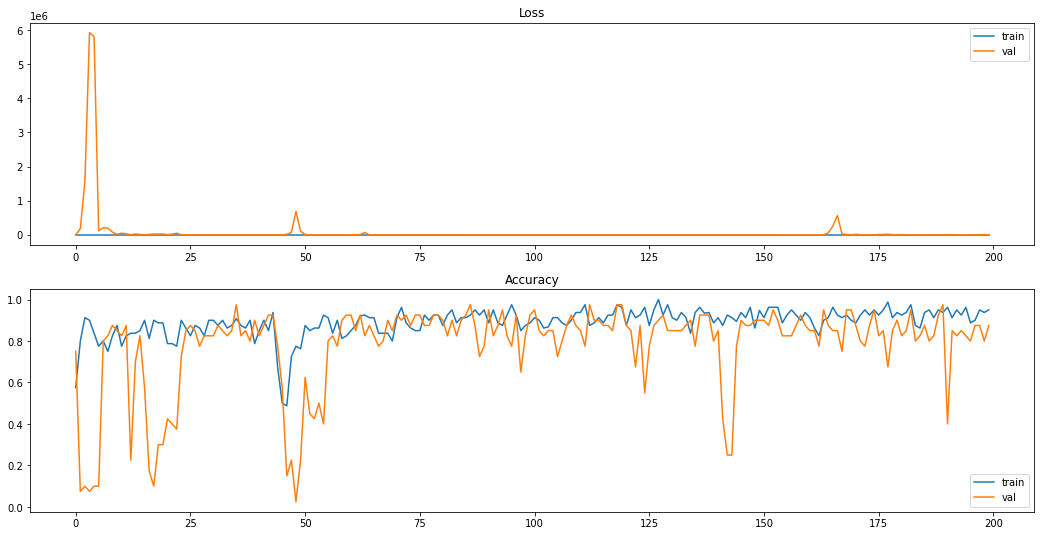

In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,9)

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.savefig('/content/drive/MyDrive/Assignments/Assignment 3/TrainTest_LossAccuracy_Graph_Inceptionv4.png')
pyplot.show()

**Generating predictions on test set: Benign and Malignant**

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image =tf.keras.utils.load_img('/content/drive/MyDrive/Assignments/Assignment 3/Custom_Dataset/Test/Benign/13.jpg',target_size = (299, 299))
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#print(result[0][0])
training_set.class_indices
if result[0][0] == 1:
  prediction = 'Malignant'
else:
  prediction = 'Benign'
print(prediction)

Benign


In [ ]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict_generator(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [ ]:
predicted_classes

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
true_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

**Generating model evaluation metrics on test set like confusion matrix, precision, recall,F1 score**

In [ ]:
import sklearn.metrics as metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      Benign       0.86      1.00      0.93      1022
   Malignant       0.00      0.00      0.00       160

    accuracy                           0.86      1182
   macro avg       0.43      0.50      0.46      1182
weighted avg       0.75      0.86      0.80      1182



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)

In [ ]:
len(true_classes)

1182

In [ ]:
len(predicted_classes)

1182

In [ ]:
confusion_matrix

array([[1022,    0],
       [ 160,    0]])

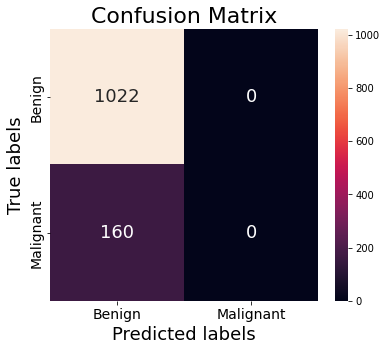

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,5)
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax, annot_kws={"fontsize":18});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=18);
ax.set_ylabel('True labels', fontsize=18);
ax.set_title('Confusion Matrix',fontsize=22);
ax.xaxis.set_ticklabels(['Benign', 'Malignant'],fontsize=14);
ax.yaxis.set_ticklabels(['Benign', 'Malignant'],fontsize=14);

plt.savefig('/content/drive/MyDrive/Assignments/Assignment 3/Confusion_Matrix_Inceptionv4.png')

Val accuracy: 72.5%, Test accuracy: 71.6%